# Implementing Logistic Regression
## Breanna Guo
## April 28th, 2024

Here is the link to my source code: https://github.com/breannaguo/csci451/blob/main/posts/Logistic%20Regression%20Blog%20Post/logistic.py

In this Blog Post, my aim is to 
- implement gradient descent for logistic regression in an object oriented paradigm
- implemenet a key variant of gradient descent with *momentum* in order to achieve faster convergence
- perform experiments to test these implementations

In logistic.py, I implement gradient descent for logistic regression. I then explore this in the following "Experimenting with data section", where I run regressions with and without momentum to observe the effects of momentum on gradeitn descent. I find that including momentum leads to much faster convergence. Finally, I explore how logistic regression may be subject to overfitting on training data. I use an example where, when tested on training data, the model achieves almost 100% accuracy, while the testing data performs significantly worse.



In [2]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
from matplotlib import pyplot as plt
import torch

### Experimenting with the data

First, generating some data to classify

Then, experimenting 
- with "normal" gradient descent where $\beta = 0$
- with momentum, $\beta > 0$

In [3]:
# The following code to create data points was prepared by Prof. Chodrow for this assignment
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

Plotting the data

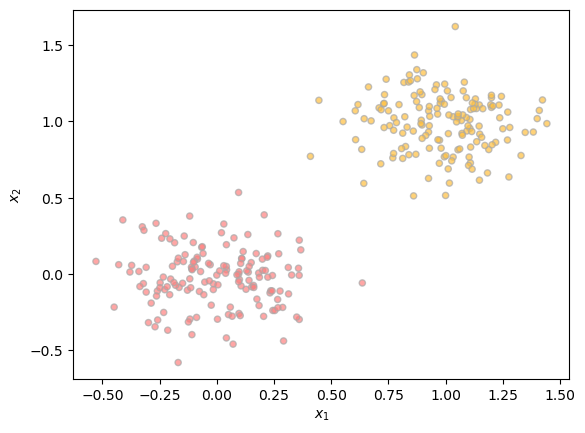

In [4]:
def plotData(X, y, ax):
    targets = [0, 1]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "spring", vmin = -2, vmax = 2, alpha = 0.7)
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
X, y = classification_data(noise = 0.2)
fig, ax = plt.subplots(1,1)

plotData(X,y,ax)

There is clear linear separability in this data!

### Vanilla/Normal Gradient Descent
When the number of features $p_{dim} = 2$, when $\alpha$ is sufficiently small and $\beta = 0$, gradient descent for logistic regression converges to a weight vector **w** that looks visually correct (plot the decision boundary with the data). Furthermore, the loss decreases monotonically (plot the loss over iterations).
This is a good experiment to use to assess whether the linear regression or the gradient descent has bugs.

The loss function is:

$w_{k+1} \leftarrow w_k - \alpha\bigtriangledown L(w_k)$

In [8]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

#initalize vector to keep track of loss over iterations
loss_vec = []

iterations = 300
for iter in range(iterations):
    opt.step(X, y, alpha = 0.5, beta = 0)
    loss = LR.loss(X, y).item()
    loss_vec.append(loss)



In [9]:
def plot_loss_fnc(loss):
    plt.plot(loss)
    plt.gca().set(xlabel = "Iteration", ylabel = "Loss")
    plt.title("Logistic Regression Loss over " + str(iterations) + " Iterations")


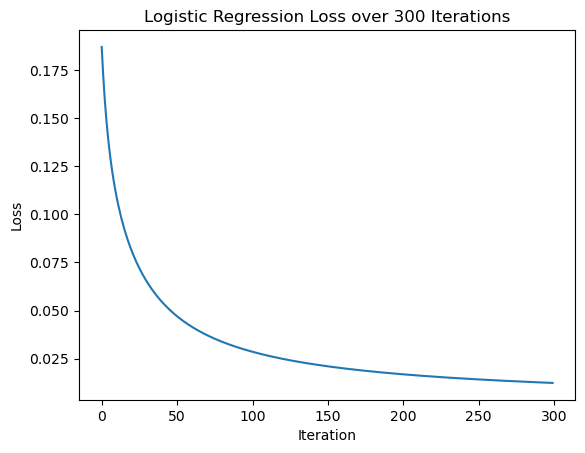

In [10]:
plot_loss_fnc(loss = loss_vec)

Interestingly, sometimes loss is monotonic and sometimes it isn't... 

Now, adding the decision boundary to the data points

In [11]:
# function to draw decision boundary
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

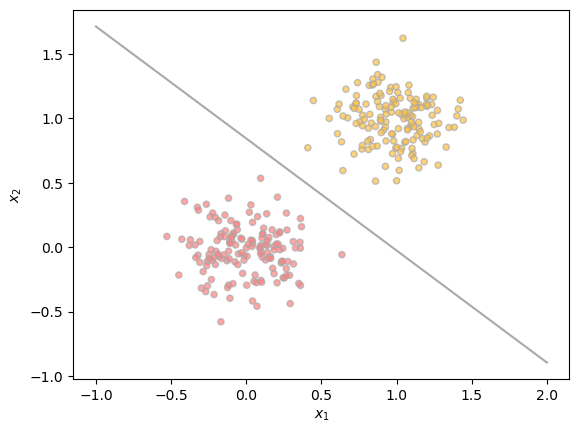

In [12]:
fig, ax = plt.subplots(1,1)
plotData(X, y, ax)
draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="darkgrey")

The decision boundary found using normal gradient descent perfectly splits the data.

### Benefits of Momentum 
On the same data, gradient descent with momentum (e.g. $\beta = 0.9$) *can* converge to the correct weight vector in fewer iterations than vanilla gradient descent (with $\beta = 0$). Plot the loss over iterations for each method. You may need to experiment with the data and choice of $\alpha$ in order to observe speedups due to momentum.

Loss function with momentum:

$w_{k+1} \leftarrow w_k - \alpha\bigtriangledown L(w_k) + \beta (w_k - w_{k-1})$ 

Notice that the loss function without momentum is whe $\beta = 0$ and the last component of the function is cancelled

Training a logistic regression model with with $\beta = 0.9$

In [29]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

#initalize vector to keep track of loss over iterations
loss_vec_momentum = []

iterations = 300
for iter in range(iterations):
    opt.step(X, y, alpha = 0.9, beta = 0.9)
    loss = LR.loss(X, y).item()
    loss_vec_momentum.append(loss)

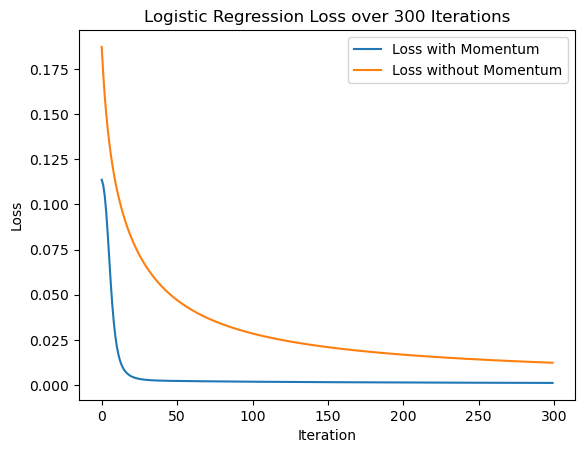

In [30]:
plot_loss_fnc(loss = loss_vec_momentum)
plot_loss_fnc(loss = loss_vec)
plt.legend(["Loss with Momentum", "Loss without Momentum"], loc = "upper right" )

It's clear from this graph that the rate at which loss is decreasing over iterations is much steeper compared to when momentum was not used!

### Overfitting
Generate some data where p_dim > n_points. For example, p_dim = 100 and n_points = 50. Do this twice with the exact same parameters. Call the first dataset X_train, y_train and the second dataset X_test, y_test. Then, do an experiment in which you fit a logistic regression model to the data X_train, y_train and obtain 100% accuracy on this training data. What is the accuracy on the test data?

Overfitting is an issue that occur with any type of machine learning algorithm, and logistic regression is particularly prone to overfitting.

In [31]:
#generating train and test data where p_dim > n_points
X_train, y_train = classification_data(n_points = 50, noise = 0.5, p_dims = 100)
X_test, y_test = classification_data(n_points = 50, noise = 0.5, p_dims = 100)

In [35]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

iterations = 100
for iter in range(iterations):
    opt.step(X_train, y_train, alpha = 0.1, beta = 0.9)

In [36]:
# Training data accuracy
(1.0*(LR.predict(X_train) == y_train)).mean()

tensor(1.)

The training data is able to get 100% accuracy

In [37]:
# Test data accuracy
(1.0*(LR.predict(X_test) == y_test)).mean()

tensor(0.9400)

The test data does significantly worse (6 percentage points) than the training data, showing how the model has been overfit

### Discussion

This exploration of logistic regression has allowed me to observe the impact of momentum on the models ability to converge quickly, in addition to the models tendency to overfit if not careful. While I noticed that loss was not monotonic, it did decrease significantly over 300 iterations, and the rate at which loss decreased was impacted by the momentum $\beta$. Ultimately, this was a very successful exploration.